# Loading the datasets into Pandas

In [16]:
!git clone https://github.com/RamtinTJB/CSE151A-Project

Cloning into 'CSE151A-Project'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 28 (delta 7), reused 15 (delta 4), pack-reused 0
Receiving objects: 100% (28/28), 429.09 KiB | 2.13 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [98]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#house_prices = pd.read_csv("CSE151A-Project/data/MedianPricesofExistingDetachedHomesHistoricalData.csv")
house_prices = pd.read_csv("data/MedianPricesofExistingDetachedHomesHistoricalData.csv")

# Data Preprocessing

In [99]:
print(f'Shape of the DataFrame: {house_prices.shape}')
print(f'Number of observations: {house_prices.shape[0]}')
print(f'Last meaningful column: {house_prices.columns[62]}')

Shape of the DataFrame: (408, 111)
Number of observations: 408
Last meaningful column: SoCal


The last meaningful column in this dataset is labeled 'SoCal' which is column number 62. Everything else after that is garbage which we need to delete.

In [100]:
cols = house_prices.columns.tolist()
house_prices = house_prices.loc[:, ~house_prices.columns.isin(cols[63:])]
house_prices.drop("Unnamed: 54", axis=1, inplace=True)

print(f'New shape: {house_prices.shape}')

New shape: (408, 62)


This dataset contains 408 rows each row correspoding to a month from 1990-2023. Since $(2023-1990+1) * 12 = 408$, no month is missing from the dataset which is good.

In [101]:
print(house_prices["Mon-Yr"])

0      32874
1      32905
2      32933
3      32964
4      32994
       ...  
403    45142
404    45170
405    45200
406    45231
407    45261
Name: Mon-Yr, Length: 408, dtype: int64


As we can see in the output above, the "Mon-Yr" column is not formatted properly and contains numbers instead of actual dates. So we'll add a new column with Python's datetime objects so that we can plot our data as a time series. The dates are from Jan-1990 to Dec-2023 based on the original data.

In [102]:
from datetime import datetime

dates_arr = [""] * 408
for year_offset in range(34):
    for month in range(12):
        dates_arr[year_offset*12 + month] = datetime(year=1990+year_offset, month=month+1, day=1)

house_prices["Dates"] = dates_arr

Now that we added a new column for dates, we can drop the "Mon-Yr" column from the dataframe.

In [103]:
house_prices.drop("Mon-Yr", axis=1, inplace=True)

Our dataset contains the monthly housing prices for all the counties in California, for the sake of this project, we decided to only analyze 5 counties and run our models on those, but it can be applied to any of the other ones in the future if needed. The counties we chose are San Diego, Los Angeles, San Fransisco, Orange, and Tulare.

In [104]:
counties = ["San Diego", "Los Angeles", "San Francisco", "Orange", "Tulare"]

#### Plotting the prices

Now we'll plot the prices over the time frame that we have to see if we need to perform more data cleaning or if we can find any interesting patterns.

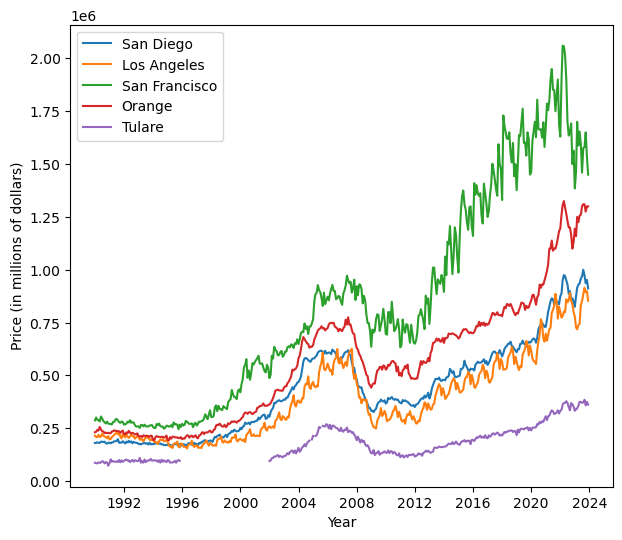

In [105]:
plt.rcParams["figure.figsize"] = (7,6)

for county in counties:
    plt.plot(house_prices["Dates"], house_prices[county], label=county)

plt.xlabel("Year")
plt.ylabel("Price (in millions of dollars)")
plt.legend()
plt.show()

#### Observations based on the graph

One common pattern we can observe in all of the counties is the sharp price fall in around 2008 which can be attributed to the 2007-2008 financial crisis.

Another common pattern is the price peak in around 2021 which also coincided with the rise in COVID-19 pandemic.

Another thing we noticed in the graph is the absense of data in between 1996 and 2001 for the Tulare county. This is because the house pricing data for those years are unavailable for the Tulare county and are marked as NA in the dataset. So we need to take care of that as well.

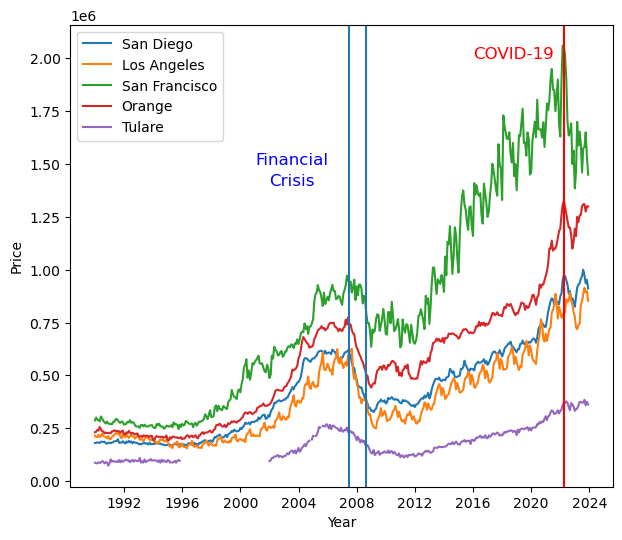

In [106]:
plt.rcParams["figure.figsize"] = (7,6)

for county in counties:
    plt.plot(house_prices["Dates"], house_prices[county], label=county)

plt.axvline(datetime(year=2007, month=7, day=1)) # August 2007
plt.axvline(datetime(year=2008, month=9, day=1)) # September 2008
plt.text(datetime(year=2001, month=1, day=1), 1.5e6, "Financial", size=12, c='b')
plt.text(datetime(year=2002, month=1, day=1), 1.4e6, "Crisis", size=12, c='b')

plt.axvline(datetime(year=2022, month=4, day=1), c='r')
plt.text(datetime(year=2016, month=1, day=1), 2e6, "COVID-19", size=12, c='r')

plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
#plt.show()
plt.savefig("Plot1.png")

#### Analazying NAs

In [107]:
for county in counties:
    print(f'{county}: {house_prices[county].isna().sum()} NAs')

San Diego: 0 NAs
Los Angeles: 0 NAs
San Francisco: 0 NAs
Orange: 0 NAs
Tulare: 76 NAs


#### Separating each county to its own DataFrame

According to the output above, only Tulare county has NA rows. For the sake of convenience, we decided to separate each county into its own dataframe.

In [152]:
county_dfs = {}

for county in counties:
    county_dfs[county] = house_prices.filter(["Dates", county], axis=1)

Now we'll interpolate the missing data in Tulare dataset that contains NA

In [153]:
county_dfs["Tulare"]["Tulare"] = county_dfs["Tulare"]["Tulare"].interpolate(method='linear')

Lastly, let's run scatters on each county individually

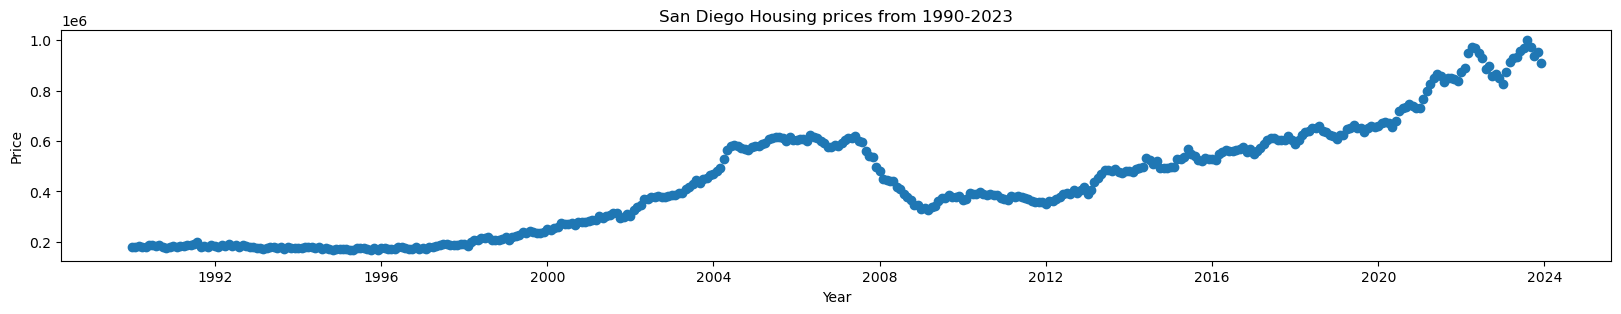

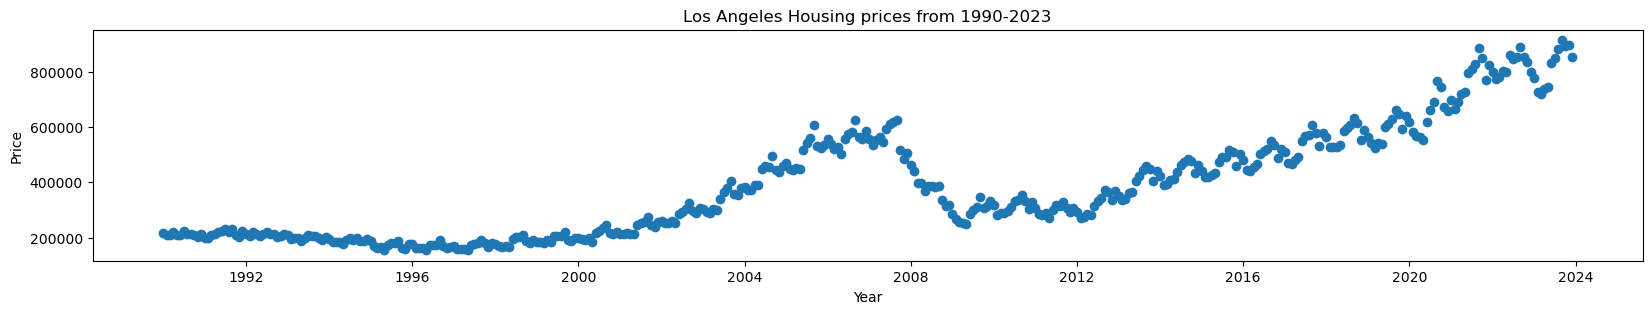

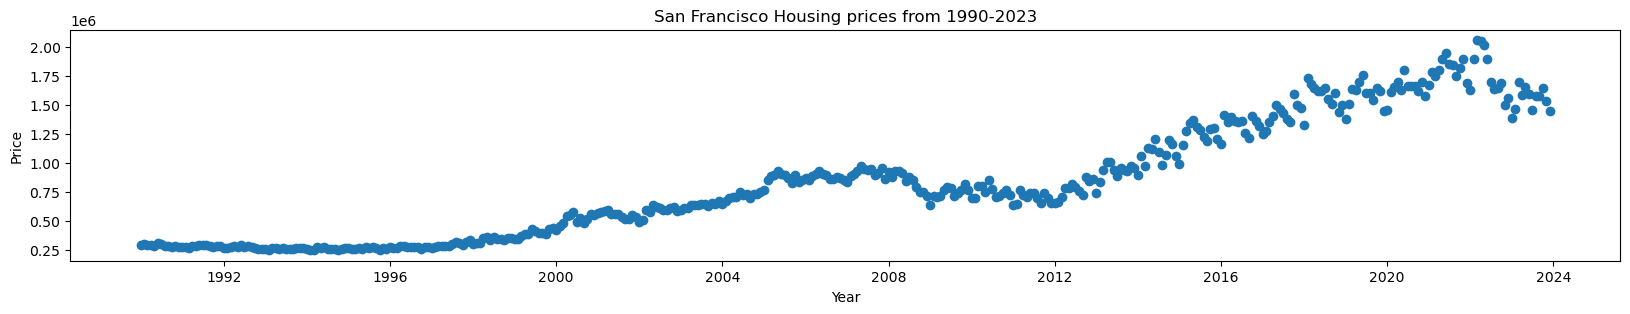

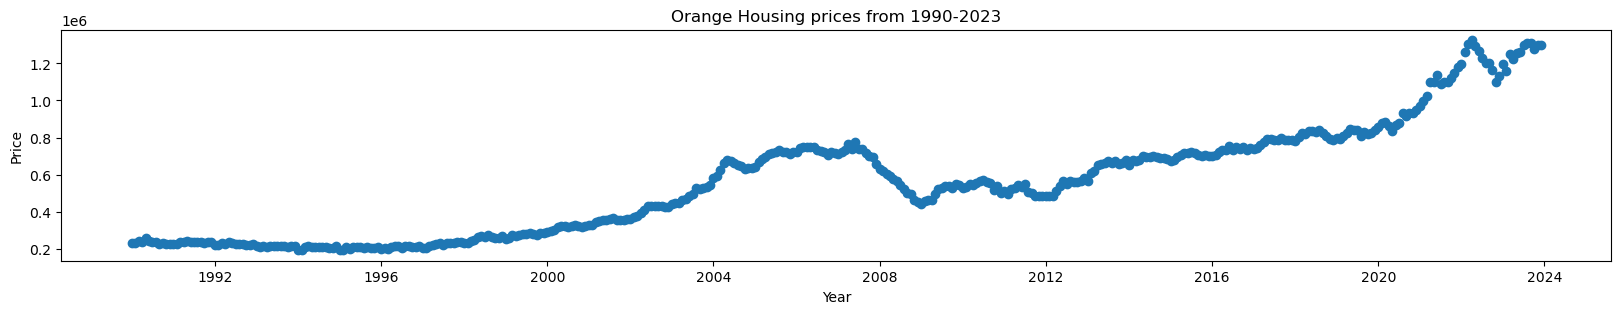

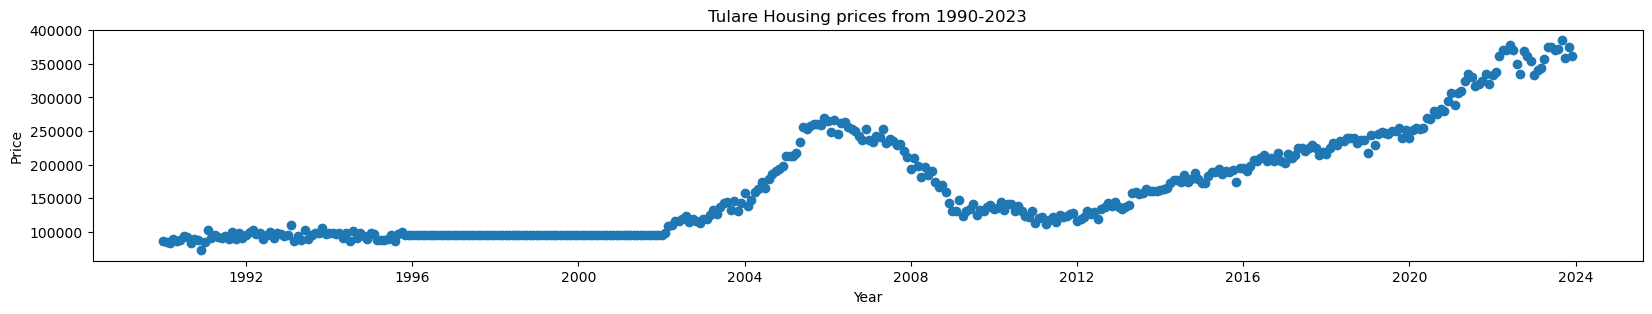

In [154]:
plt.rcParams["figure.figsize"] = (20,3)

for county in counties:
    plt.scatter(county_dfs[county]["Dates"], county_dfs[county][county])
    plt.title(f'{county} Housing prices from 1990-2023')
    plt.xlabel("Year")
    plt.ylabel("Price")
    plt.show()

### Median Income Preprocessing

Now let's load the median income dataset and see if we need to do any preprocessing on it.

In [65]:
median_income_dict = {}

for county in counties:
    median_income_dict[county] = {}
    cn = county.replace(" ", "")
    median_income_dict[county]["df"] = pd.read_csv(f'data/{cn}MedianIncome.csv')

for county in counties:
    print(f'{county}: Shape {median_income_dict[county]["df"].shape}')
    print(median_income_dict[county]["df"].head())

San Diego: Shape (34, 2)
         DATE MHICA06073A052NCEN
0  1989-01-01              31627
1  1990-01-01                  .
2  1991-01-01                  .
3  1992-01-01                  .
4  1993-01-01              35648
Los Angeles: Shape (34, 2)
         DATE MHICA06037A052NCEN
0  1989-01-01              31123
1  1990-01-01                  .
2  1991-01-01                  .
3  1992-01-01                  .
4  1993-01-01              32689
San Francisco: Shape (34, 2)
         DATE MHICA06075A052NCEN
0  1989-01-01              30166
1  1990-01-01                  .
2  1991-01-01                  .
3  1992-01-01                  .
4  1993-01-01              34623
Orange: Shape (34, 2)
         DATE MHICA06059A052NCEN
0  1989-01-01              39592
1  1990-01-01                  .
2  1991-01-01                  .
3  1992-01-01                  .
4  1993-01-01              45116
Tulare: Shape (34, 2)
         DATE MHICA06107A052NCEN
0  1989-01-01              21571
1  1990-01-01    

Now we need to change the column names for each county and set it to median income. We also need to change the date to Python's date time object to have a time series. To do that, we will first create a new column for the date time series and then we will drop the original date column.

In [66]:
for county in counties:
    median_income_dict[county]["df"].rename(columns={median_income_dict[county]["df"].columns[1]: f"{county} Median Income"}, inplace=True)

# To test if it worked
print(median_income_dict["Tulare"]["df"].head())

         DATE Tulare Median Income
0  1989-01-01                21571
1  1990-01-01                    .
2  1991-01-01                    .
3  1992-01-01                    .
4  1993-01-01                23927


In [67]:
dates_arr = [""] * 34
for year_offset in range(34):
    dates_arr[year_offset] = datetime(year=1989+year_offset, month=1, day=1)

for county in counties:
    median_income_dict[county]["df"]["Dates"] = dates_arr
    median_income_dict[county]["df"].drop(columns="DATE", inplace=True)

In [74]:
print(median_income_dict["Tulare"]["df"].head())

   Tulare Median Income      Dates
0               21571.0 1989-01-01
1                   NaN 1990-01-01
2                   NaN 1991-01-01
3                   NaN 1992-01-01
4               23927.0 1993-01-01


We also need to change the data type of the Median Income column from string to numeric

In [70]:
for county in counties:
    median_income_dict[county]["df"].replace('.', np.nan, inplace=True)
    median_income_dict[county]["df"][f'{county} Median Income'] = pd.to_numeric(median_income_dict[county]["df"][f'{county} Median Income'])

Now let's graph the median income data

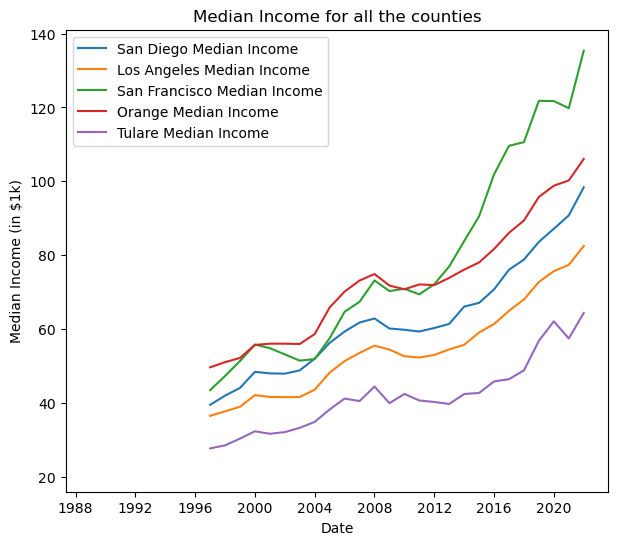

In [78]:
plt.rcParams["figure.figsize"] = (7,6)

for county in counties:
    plt.plot(median_income_dict[county]["df"]["Dates"], median_income_dict[county]["df"][f'{county} Median Income'] / 1000, label=f'{county} Median Income')

plt.legend()
plt.title("Median Income for all the counties")
plt.xlabel("Date")
plt.ylabel("Median Income (in $1k)")
plt.show()

#### Interpolating the missing data

In [82]:
for county in counties:
    median_income_dict[county]["df"][f"{county} Median Income"] = \
        median_income_dict[county]["df"][f"{county} Median Income"].interpolate()

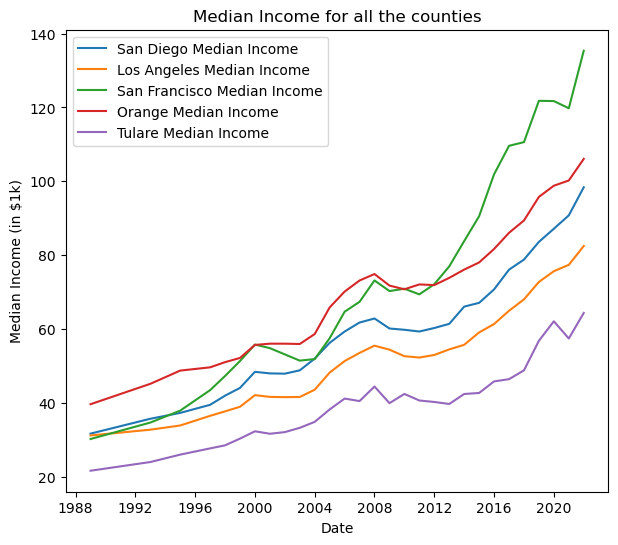

In [83]:
plt.rcParams["figure.figsize"] = (7,6)

for county in counties:
    plt.plot(median_income_dict[county]["df"]["Dates"], median_income_dict[county]["df"][f'{county} Median Income'] / 1000, label=f'{county} Median Income')

plt.legend()
plt.title("Median Income for all the counties")
plt.xlabel("Date")
plt.ylabel("Median Income (in $1k)")
plt.show()

#### Encoding the dates for the housing prices and median income to perform linear regression

To run a linear regression model on our housing prices, we can think of our independent variable as the number of days from the first data point in the dataset.

In [166]:
for county in counties:
    county_dfs[county]["DATE_ENC"] = county_dfs[county]["Dates"] - county_dfs[county]["Dates"][0]
    county_dfs[county]["DATE_ENC"] = county_dfs[county]["DATE_ENC"].apply(lambda x: int(x.days))

In [170]:
for county in counties:
    print(county_dfs[county].head())

       Dates  San Diego  DATE_ENC
0 1990-01-01   180484.0         0
1 1990-02-01   180714.0        31
2 1990-03-01   183701.0        59
3 1990-04-01   181567.0        90
4 1990-05-01   180794.0       120
       Dates  Los Angeles  DATE_ENC
0 1990-01-01  215337.9260         0
1 1990-02-01  208399.1179        31
2 1990-03-01  208134.8627        59
3 1990-04-01  219003.9896        90
4 1990-05-01  209065.0242       120
       Dates  San Francisco  DATE_ENC
0 1990-01-01         287499         0
1 1990-02-01         300877        31
2 1990-03-01         290151        59
3 1990-04-01         288725        90
4 1990-05-01         282626       120
       Dates       Orange  DATE_ENC
0 1990-01-01  231273.8907         0
1 1990-02-01  233655.5767        31
2 1990-03-01  242312.4975        59
3 1990-04-01  239380.4948        90
4 1990-05-01  256401.3846       120
       Dates       Tulare  DATE_ENC
0 1990-01-01  86999.30000         0
1 1990-02-01  84374.56250        31
2 1990-03-01  84210.10526   

In [172]:
for county in counties:
    median_income_dict[county]["df"]["DATE_ENC"] = median_income_dict[county]["df"]["Dates"] - median_income_dict[county]["df"]["Dates"][0]
    median_income_dict[county]["df"]["DATE_ENC"] = median_income_dict[county]["df"]["DATE_ENC"].apply(lambda x: int(x.days))

In [174]:
for county in counties:
    print(median_income_dict[county]["df"].head())

   San Diego Median Income      Dates  DATE_ENC
0                 31627.00 1989-01-01         0
1                 32632.25 1990-01-01       365
2                 33637.50 1991-01-01       730
3                 34642.75 1992-01-01      1095
4                 35648.00 1993-01-01      1461
   Los Angeles Median Income      Dates  DATE_ENC
0                    31123.0 1989-01-01         0
1                    31514.5 1990-01-01       365
2                    31906.0 1991-01-01       730
3                    32297.5 1992-01-01      1095
4                    32689.0 1993-01-01      1461
   San Francisco Median Income      Dates  DATE_ENC
0                     30166.00 1989-01-01         0
1                     31280.25 1990-01-01       365
2                     32394.50 1991-01-01       730
3                     33508.75 1992-01-01      1095
4                     34623.00 1993-01-01      1461
   Orange Median Income      Dates  DATE_ENC
0               39592.0 1989-01-01         0
1         

## Model 1

For our first model, we'll train a separate linear regression model on each county's housing prices and median income, and then we'll use the prediction of these values to calculate the Housing Affordability Index for any given year.

In [177]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

San Diego Housing Price Linear Model:
	Train MSE:   9873528504.099745
	Test  MSE:   10844673410.050852
	Coefficient: 55.06403849683388
	Intercept:   94399.4862997086



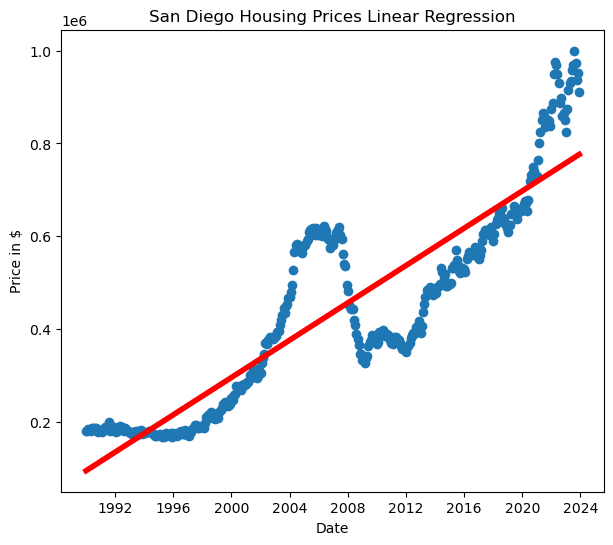

Los Angeles Housing Price Linear Model:
	Train MSE:   10596126101.819113
	Test  MSE:   10319837757.869236
	Coefficient: 47.66637762000854
	Intercept:   96114.53174390714



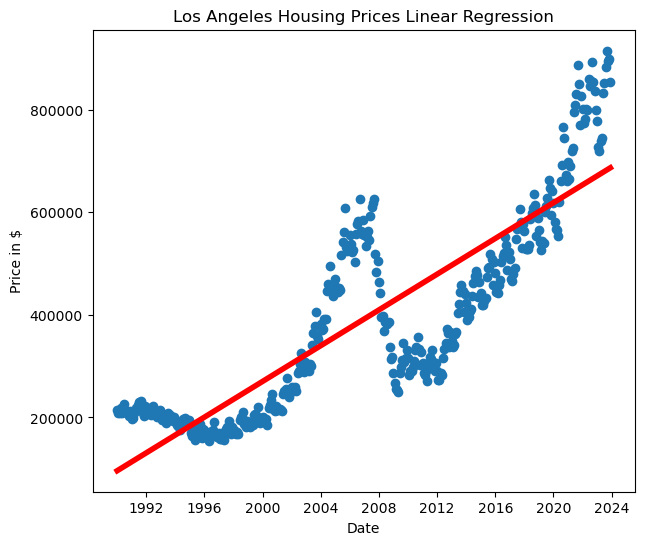

San Francisco Housing Price Linear Model:
	Train MSE:   27290057196.46368
	Test  MSE:   28257240671.31636
	Coefficient: 132.61934884335986
	Intercept:   13263.896493805689



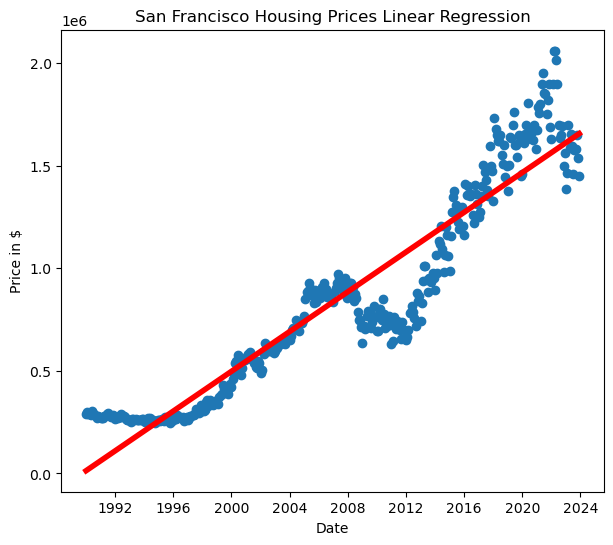

Orange Housing Price Linear Model:
	Train MSE:   13876777128.553144
	Test  MSE:   14064546197.695322
	Coefficient: 76.00820514368324
	Intercept:   87934.00198478042



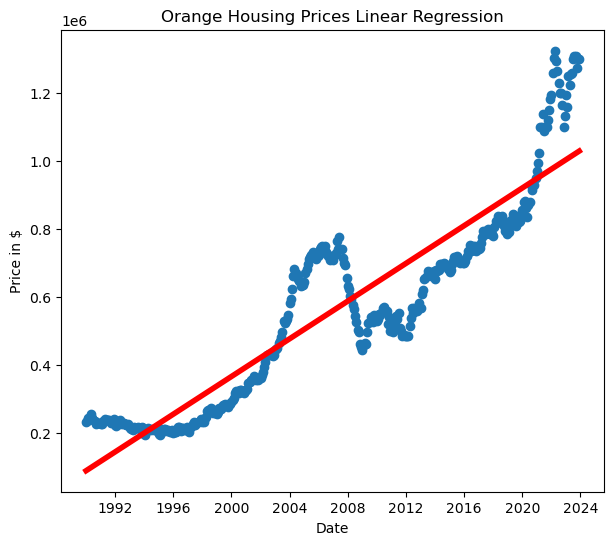

Tulare Housing Price Linear Model:
	Train MSE:   2059420234.3871853
	Test  MSE:   2328833925.596119
	Coefficient: 18.64278105439823
	Intercept:   53529.715464411755



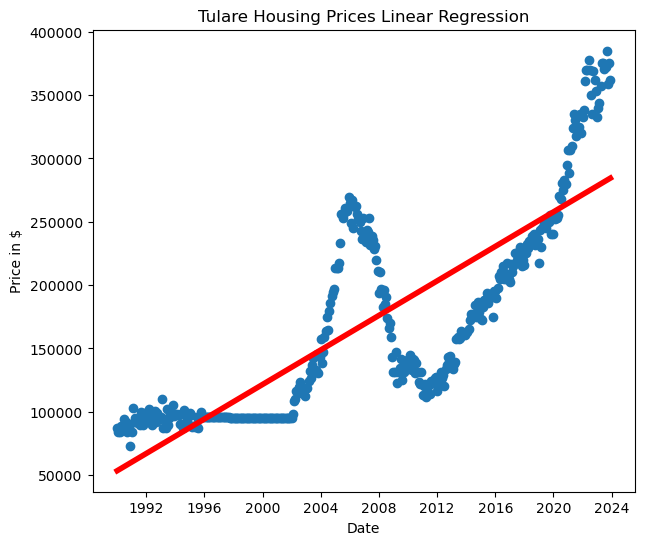

In [208]:
plt.rcParams["figure.figsize"] = (7,6)
linear_dict = {}

for county in counties:
    key = f'{county}_hp'
    linear_dict[key] = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(county_dfs[county]["DATE_ENC"].to_numpy().reshape(-1,1), \
                                                        county_dfs[county][county], test_size=0.2, random_state=15)
    linear_dict[key].fit(X_train, y_train)

    print(f'{county} Housing Price Linear Model:')
    y_test_pred = linear_dict[key].predict(X_test)
    y_train_pred = linear_dict[key].predict(X_train)
    print(f'\tTrain MSE:   {mean_squared_error(y_train, y_train_pred)}')
    print(f'\tTest  MSE:   {mean_squared_error(y_test, y_test_pred)}')
    print(f'\tCoefficient: {linear_dict[key].coef_[0]}')
    print(f'\tIntercept:   {linear_dict[key].intercept_}')
    print()

    plt.scatter(county_dfs[county]["Dates"], county_dfs[county][county])
    plt.plot(county_dfs[county]["Dates"], linear_dict[key].predict(county_dfs[county]["DATE_ENC"].to_numpy().reshape(-1,1)), c='r', linewidth=4)
    plt.title(f'{county} Housing Prices Linear Regression')
    plt.xlabel("Date")
    plt.ylabel("Price in $")
    plt.show()

San Diego Median Income Linear Model:
	Train MSE:   17813098.91095283
	Test  MSE:   23641532.03337252
	Coefficient: 4.730315532156534
	Intercept:   27632.53220065524



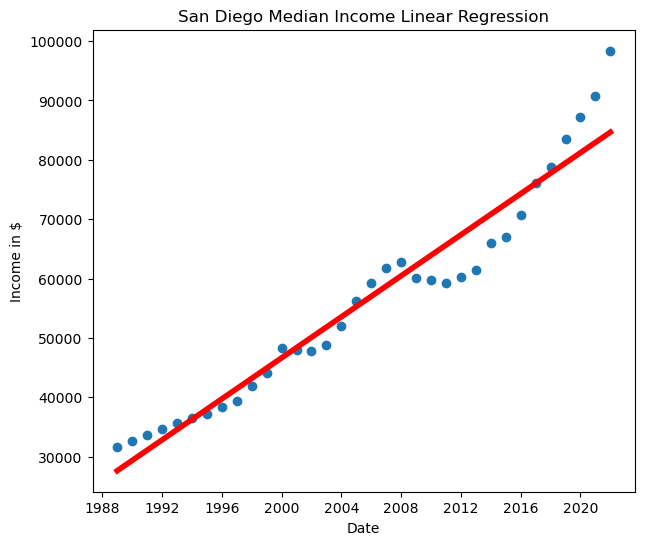

Los Angeles Median Income Linear Model:
	Train MSE:   12129142.010608856
	Test  MSE:   22594198.74532475
	Coefficient: 3.833019882120458
	Intercept:   26356.169902231755



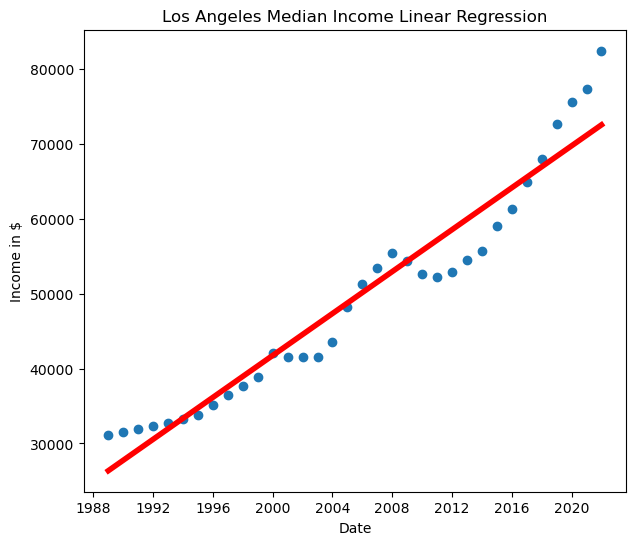

San Francisco Median Income Linear Model:
	Train MSE:   70355211.45651138
	Test  MSE:   77734614.31184067
	Coefficient: 7.923985458212508
	Intercept:   20613.263647687505



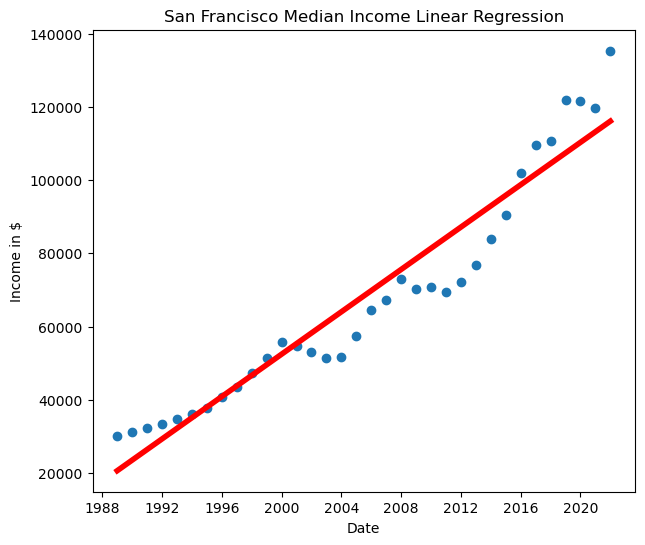

Orange Median Income Linear Model:
	Train MSE:   14802910.001320057
	Test  MSE:   25133392.49731798
	Coefficient: 4.940845400946809
	Intercept:   36468.038890809716



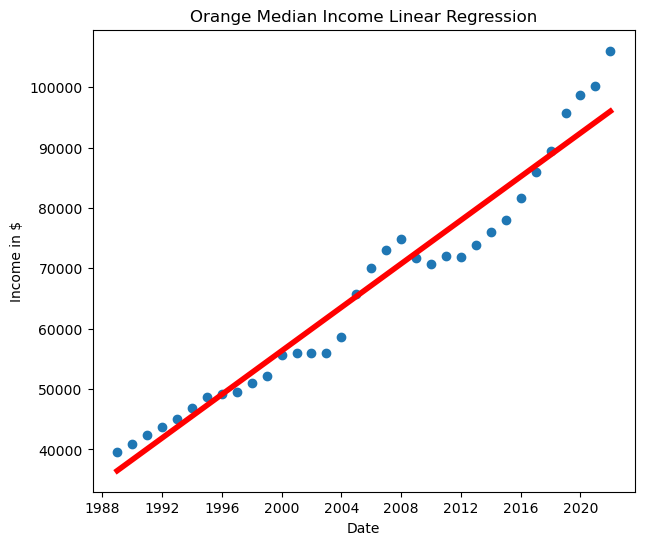

Tulare Median Income Linear Model:
	Train MSE:   11335763.52725025
	Test  MSE:   8103237.973512655
	Coefficient: 3.0253862975633155
	Intercept:   19333.723344157715



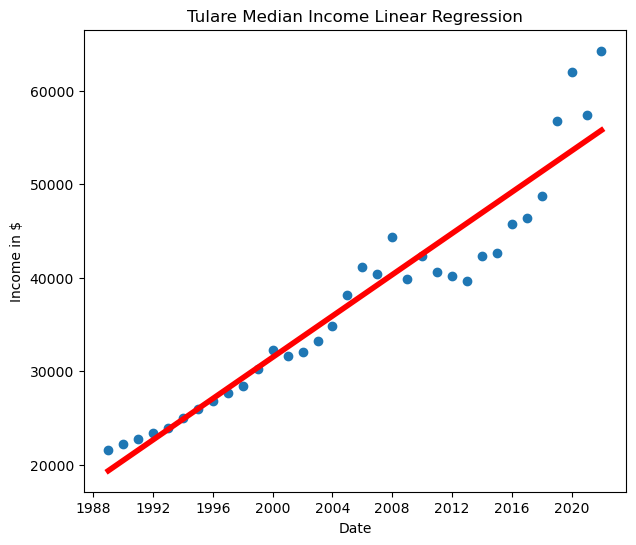

In [214]:
for county in counties:
    key = f'{county}_mi'
    linear_dict[key] = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(median_income_dict[county]['df']["DATE_ENC"].to_numpy().reshape(-1,1), \
                                                        median_income_dict[county]['df'][f"{county} Median Income"], test_size=0.1, \
                                                        random_state=15)
    linear_dict[key].fit(X_train, y_train)

    print(f'{county} Median Income Linear Model:')
    y_test_pred = linear_dict[key].predict(X_test)
    y_train_pred = linear_dict[key].predict(X_train)
    print(f'\tTrain MSE:   {mean_squared_error(y_train, y_train_pred)}')
    print(f'\tTest  MSE:   {mean_squared_error(y_test, y_test_pred)}')
    print(f'\tCoefficient: {linear_dict[key].coef_[0]}')
    print(f'\tIntercept:   {linear_dict[key].intercept_}')
    print()

    plt.scatter(median_income_dict[county]['df']["Dates"], median_income_dict[county]['df'][f"{county} Median Income"])
    plt.plot(median_income_dict[county]['df']["Dates"], linear_dict[key].predict(median_income_dict[county]['df']["DATE_ENC"].to_numpy().reshape(-1,1)), c='r', linewidth=4)
    plt.title(f'{county} Median Income Linear Regression')
    plt.xlabel("Date")
    plt.ylabel("Income in $")
    plt.show()

In [276]:
#Input stuff

interest_rate = 0.038
input_date = datetime(year=2022, month=2, day=24)
input_county = "San Diego"

In [284]:
encoded_date_income = int((input_date - median_income_dict[input_county]["df"]["Dates"][0]).days)
encoded_date_housing = int((input_date - county_dfs[input_county]["Dates"][0]).days)

median_income = linear_dict[f'{input_county}_mi'].predict(np.array([encoded_date_income]).reshape(-1,1))
housing_price = linear_dict[f'{input_county}_hp'].predict(np.array([encoded_date_housing]).reshape(-1, 1)) 

pmt = housing_price * 0.8 * (interest_rate / 12) / (1-(1/((1+interest_rate/12)**360)))
qinc = pmt * 48
hai = median_income / qinc * 100
print(f'The Housing Affordability in {input_date.strftime("%B %Y")} is predicted to be {hai[0]:.4}%')

The Housing Affordability in February 2022 is predicted to be 64.04%
